In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('../Data/df_transformed.csv')

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.columns

Index(['LBXTC', 'RIAGENDR', 'RIDRETH3', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BPXPLS', 'BPXPULS', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA', 'DR1_300',
       'ALQ120Q', 'ALQ120U', 'ALQ130', 'BPQ020', 'BPQ050A', 'BPQ080',
       'BPQ100D', 'DIQ010', 'MCQ170M', 'SMQ681', 'PAQ610', 'PAD615', 'PAQ625',
       'PAD630', 'PAQ655', 'PAD660', 'PAQ670', 'PAD675', 'Systolic',
       'Diastolic', 'MET_work', 'MET_rec', 'DR1TKCAL_t', 'DR1TPROT_t',
       'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t', 'DR1TSFAT_t',
       'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t', 'DR1TVD_t',
       'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t', 'log_LBXTC'],
      dtype='object')

First I'm going to try with demographic information, body mass index, blood pressure, pulse, nutrition info (not transformed) and MET recreational.  Because KNN uses distance, any categorical, non oridnal, values with more than two levels such as race, need to be one hot encoded because we want the distances to be the same between any two races.  I will also first try with y being LBXTC and not log transformed.
I plan to first drop missing values then try it with imputed missing values

In [8]:
numerical_variables = ['RIAGENDR','RIDAGEYR','BMXBMI','BPXPLS','DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA','MET_rec']
categorical_variables = ['RIDRETH3','DR1_300']

In [9]:
df1 = df[numerical_variables+categorical_variables+['LBXTC']].copy()

In [10]:
df1.dropna(inplace=True)

In [12]:
y = df1.LBXTC
X = df1.drop('LBXTC', axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=625)

In [15]:
numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numerical_variables),
    ('cat',cat_transformer,categorical_variables)])

In [16]:
knn1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_regression', KNeighborsRegressor())])

In [19]:
params = {
    'knn_regression__weights':['uniform', 'distance'],
    'knn_regression__n_neighbors':[1, 2,5,10, 20,50,100]
}

In [20]:
grid1 = GridSearchCV(knn1,params,scoring='neg_mean_absolute_error',verbose=0)
grid1.fit(X_train,y_train)
grid1.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END knn_regression__n_neighbors=1, knn_regression__weights=uniform;, score=-43.635 total time=   0.0s
[CV 2/5] END knn_regression__n_neighbors=1, knn_regression__weights=uniform;, score=-44.143 total time=   0.0s
[CV 3/5] END knn_regression__n_neighbors=1, knn_regression__weights=uniform;, score=-40.676 total time=   0.0s
[CV 4/5] END knn_regression__n_neighbors=1, knn_regression__weights=uniform;, score=-44.191 total time=   0.0s
[CV 5/5] END knn_regression__n_neighbors=1, knn_regression__weights=uniform;, score=-44.501 total time=   0.0s
[CV 1/5] END knn_regression__n_neighbors=1, knn_regression__weights=distance;, score=-43.635 total time=   0.0s
[CV 2/5] END knn_regression__n_neighbors=1, knn_regression__weights=distance;, score=-44.143 total time=   0.0s
[CV 3/5] END knn_regression__n_neighbors=1, knn_regression__weights=distance;, score=-40.676 total time=   0.0s
[CV 4/5] END knn_regression__n_neighbors=1, knn_

{'knn_regression__n_neighbors': 50, 'knn_regression__weights': 'distance'}

In [21]:
grid1.best_score_

-31.634678286793154

In [23]:
y_preds = grid1.predict(X_test)
print('Mean Absolute error for test set:',mean_absolute_error(y_test, y_preds))

Mean Absolute error for test set: 31.994752241358416


The test and train scores are similar. There doesn't appear to be underfitting.  However that is a large MAE.  In context someone with cholesterol level of 170 may in fact have high cholesterol.    Looking at the plot of residuals..

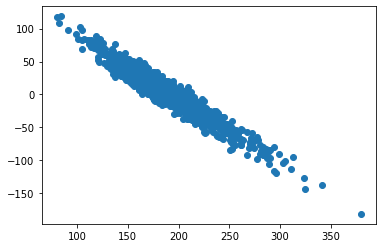

In [26]:
residuals = y_preds-y_test
plt.scatter(y_test,residuals)

Notice this is not a good model.  The residuals should be randomly scattered centered at 0

(array([  1.,   0.,   0.,   2.,   1.,   3.,   4.,  11.,  18.,  23.,  32.,
         41.,  61.,  69., 119., 109., 119.,  93.,  74.,  63.,  28.,  19.,
          7.,   3.,   3.]),
 array([-181.60941947, -169.59342372, -157.57742796, -145.56143221,
        -133.54543645, -121.5294407 , -109.51344495,  -97.49744919,
         -85.48145344,  -73.46545768,  -61.44946193,  -49.43346617,
         -37.41747042,  -25.40147466,  -13.38547891,   -1.36948316,
          10.6465126 ,   22.66250835,   34.67850411,   46.69449986,
          58.71049562,   70.72649137,   82.74248713,   94.75848288,
         106.77447863,  118.79047439]),
 <BarContainer object of 25 artists>)

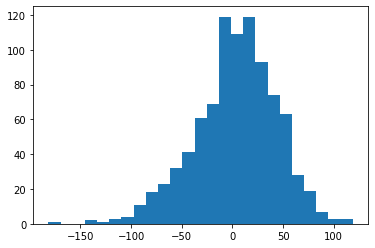

In [27]:
plt.hist(residuals,bins=25)

The histogram of the residuals is left skewed.  